In [1]:
import torch
import os
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
from tqdm import tqdm
import supervision as sv
import matplotlib.pyplot as plt
import tifffile
import numpy as np
import glob
import logging
from torch.utils.data import random_split
import random
import multiprocessing
import logging
import time
from concurrent.futures import ProcessPoolExecutor
from four_colouring import process_sam_output, visualize_colored_masks

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

DEVICE = torch.device('cuda')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam,
                                           points_per_side=64,
        points_per_batch=128,
        pred_iou_thresh=0.7,
        stability_score_thresh=0.92,
        stability_score_offset=0.7,
        crop_n_layers=1,
        box_nms_thresh=0.7,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=25.0,
)


In [3]:

img = cv2.imread("/home/sow/Documents/domain_adaptation/PRISM-UDA/data/I3/patches_dataset/patch_0098/0005.jpg")

save_path = "/home/sow/Documents/domain_adaptation/PRISM-UDA/data/WeiH/"

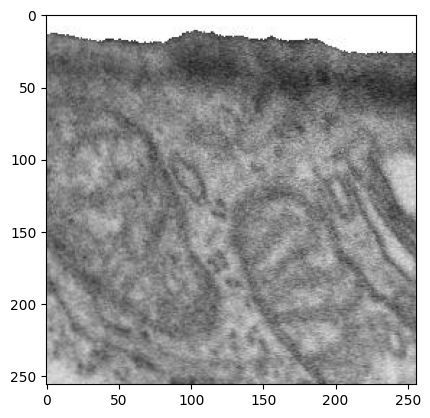

In [4]:
plt.imshow(img)

In [5]:
masks = mask_generator.generate(img)
colored_mask = process_sam_output(masks)
visualize_colored_masks(colored_mask=colored_mask,save_path=save_path+"test.png")

	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


Finding mask adjacencies...
Applying graph coloring...
Creating colored mask...


array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4]], dtype=uint8)

In [5]:
len(masks)

49

In [11]:
def process_single_image(image_path, output_dir):

    
    try:
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            return f"Failed to read image: {image_path}"
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for citysapes
        
        # Create output path
        image_name = os.path.basename(image_path)
        os.makedirs(output_dir, exist_ok=True)
        print(image_name)
        print(output_dir)
        
        # Generate masks
        masks = mask_generator.generate(image)
        
        if not masks:
            return f"No masks generated for {image_path}"
        
        
        colored_mask = process_sam_output(masks)
        visualize_colored_masks(colored_mask=colored_mask,save_path=output_dir+image_name)
        

        return f"Successfully processed {image_path}"
        
    except Exception as e:
        return f"Error processing {image_path}: {str(e)}"

In [12]:
process_single_image("/home/sow/Documents/domain_adaptation/PRISM-UDA/data/WeiH/images/1.png",save_path+"test/")

1.png
/home/sow/Documents/domain_adaptation/PRISM-UDA/data/WeiH/test/
Finding mask adjacencies...
Applying graph coloring...
Creating colored mask...


'Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/WeiH/images/1.png'

In [8]:
def filtre(image_path:str):
    if not image_path.endswith("_pseudoTrainIds.png"):
        return image_path

In [15]:
gta_images = list(mmcv.scandir(gta_input_path,".png",recursive=True))
gta_sam = list(filter(filtre,mmcv.scandir(gta_output_path,".png",recursive=True)))


In [21]:
def filter2(image_path:str):
    if image_path not in gta_sam:
        return image_path

In [22]:
list(filter(filter2,gta_images))

['17705.png', '15188.png']

In [24]:
gta_1 = os.path.join(gta_input_path,'17705.png')
gta_2 = os.path.join(gta_input_path,'15188.png')

In [30]:
def process_all(input_dir,output_dir):

    #create the sam directory if not created
    os.makedirs(os.path.join(output_dir),exist_ok=True)
    image_files = glob.glob(os.path.join(input_dir,"**","*.png"),recursive=True)
        
    
    for image_path in image_files:
        out = process_single_image(image_path,output_dir)
        print(out)
    
    return image_files

In [31]:
# process gta images
process_all(input_dir=gta_input_path,output_dir=gta_output_path)

Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/05365.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/21265.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/07079.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/09103.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/02127.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/18876.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/05413.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/24382.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/12556.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/00439.png
Successfully processed /home/s

['/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/05365.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/21265.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/07079.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/09103.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/02127.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/18876.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/05413.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/24382.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/12556.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/00439.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/10569.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/images/18155.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/image

In [34]:
# process cityscapes images
process_all(input_dir=cityscapes_input_path,output_dir=cityscapes_output_path)

Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000106_000019_leftImg8bit.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000176_000019_leftImg8bit.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000166_000019_leftImg8bit.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000028_000019_leftImg8bit.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000073_000019_leftImg8bit.png
Successfully processed /home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000212_000019_leftImg8bit.png
Successfully processed /home/sow/Documents/domain_adaptati

['/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000106_000019_leftImg8bit.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000176_000019_leftImg8bit.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000166_000019_leftImg8bit.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000028_000019_leftImg8bit.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000073_000019_leftImg8bit.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000212_000019_leftImg8bit.png',
 '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000006_000019_leftImg8bit.png',
 '/home/sow/Documents/domain_adapt

In [ ]:
list_img = []
list_mask = []
list_pred = []
for i in tqdm(range(img_lw4.shape[0])) :
    for i in tqdm(range(120)) : #120 slices with reticulum
        image = cv2.cvtColor(img_lw4[i,:,:], cv2.COLOR_BGR2RGB)
        list_pred.append(get_pred(image))
        list_img.append(img_lw4[i,:,:])
        list_mask.append(mask_lw4[i,:,:])
    stacked_array_img = np.stack(list_img)
    stacked_array_mask = np.stack(list_mask)
    stacked_array_pred  =  np.stack(list_pred)
    tifffile.imwrite('lw4_reti.tiff', stacked_array_img)
    tifffile.imwrite('mask_reti_lw4.tiff', stacked_array_mask)
    tifffile.imwrite('pred_sam_reti_lw4.tiff', stacked_array_pred)